# Load the dataset

In [1]:
# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Load the IMDB movie review dataset, return text (movie review) and label (positive/negative)
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [3]:
# Show same samples in the training set
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

# Analyze and process the dataset

## Convert the TensorFlow Dataset to NumPy arrays

In [4]:
# Helper function to convert TensorFlow Datasets to NumPy arrays
def dataset_to_numpy(dataset):
    texts = []
    labels = []
    for text, label in tfds.as_numpy(dataset):
        texts.append(text.decode('utf-8'))  # Decode bytes to string
        labels.append(label)
    return np.array(texts), np.array(labels)

# Convert the datasets to NumPy arrays
X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# Print the shapes of the datasets
print("Training set shape: ", X_train.shape, y_train.shape)
print("Validation set shape: ", X_val.shape, y_val.shape)
print("Test set shape: ", X_test.shape, y_test.shape)

Training set shape:  (20000,) (20000,)
Validation set shape:  (5000,) (5000,)
Test set shape:  (25000,) (25000,)


## Build and adapt the TextVectorization layer

In [5]:
# Set the vocabulary size and the output sequence length
VOCAB_SIZE = 5000  # Limit the vocabulary to the top 1000 words
MAX_SEQUENCE_LENGTH = 100  # Maximum length of sequences (padded or truncated)

# Initialize the TextVectorization layer
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,  # The maximum number of unique tokens in the vocabulary
    output_mode='int',  # Output mode: integer indices
    output_sequence_length=MAX_SEQUENCE_LENGTH  # Fixed length of sequences for padding
)

# Adapt the vectorizer to the training data to build the vocabulary
text_vectorizer.adapt(X_train)

print("Vocabulary size: ", len(text_vectorizer.get_vocabulary()))

Vocabulary size:  5000


## Test and apply text vectorization

In [6]:
# Test the TextVectorization layer on a sample text
sample_text = "This movie was amazing! The acting was incredible and the story was captivating."
vectorized_text = text_vectorizer([sample_text])

print("Original text: ", sample_text)
print("Vectorized text: ", vectorized_text.numpy())

Original text:  This movie was amazing! The acting was incredible and the story was captivating.
Vectorized text:  [[  11   18   14  491    2  115   14 1045    3    2   64   14 3772    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [7]:
# Vectorize the entire training, validation, and test datasets
X_train_vectorized = text_vectorizer(X_train).numpy()
X_val_vectorized = text_vectorizer(X_val).numpy()
X_test_vectorized = text_vectorizer(X_test).numpy()

print("Vectorized training data shape: ", X_train_vectorized.shape)
print("Vectorized validation data shape: ", X_val_vectorized.shape)
print("Vectorized test data shape: ", X_test_vectorized.shape)

Vectorized training data shape:  (20000, 100)
Vectorized validation data shape:  (5000, 100)
Vectorized test data shape:  (25000, 100)


# Construct an RNN model using GRU

## Train

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Constructing a GRU-based RNN model
gru_model = models.Sequential([
    layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),
    layers.GRU(64),
    layers.Dense(1, activation='sigmoid')
])

gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the GRU model
history_gru = gru_model.fit(X_train_vectorized, y_train, epochs=10, validation_data=(X_val_vectorized, y_val), batch_size=32)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5598 - loss: 0.6704 - val_accuracy: 0.7872 - val_loss: 0.4673
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8261 - loss: 0.4069 - val_accuracy: 0.8246 - val_loss: 0.3901
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8778 - loss: 0.3014 - val_accuracy: 0.8320 - val_loss: 0.3946
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9151 - loss: 0.2249 - val_accuracy: 0.8234 - val_loss: 0.4306
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9392 - loss: 0.1701 - val_accuracy: 0.8184 - val_loss: 0.5175
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9556 - loss: 0.1285 - val_accuracy: 0.8054 - val_loss: 0.5473
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9740 - loss: 0.0847 - val_accuracy: 0.8072 - val_loss: 0.7441
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9830 - loss: 0.0576 - val_accuracy: 0.7928 - va

## Test and evaluate

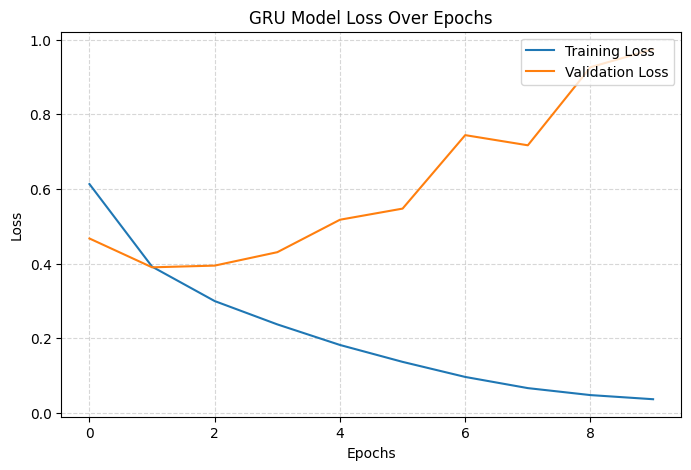

In [9]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

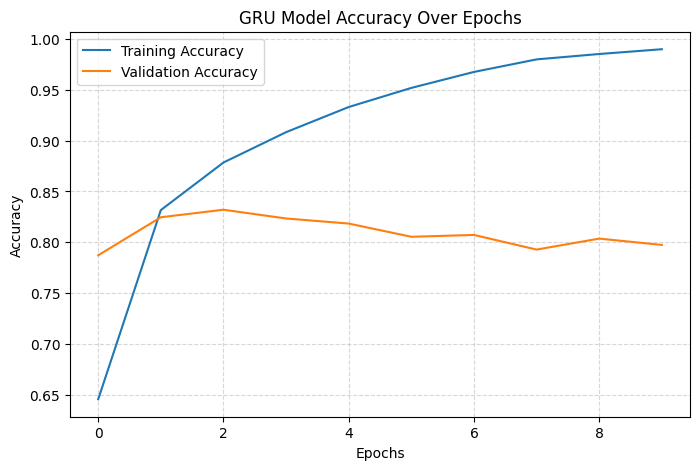

In [10]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

In [11]:
# Evaluate the GRU model on the test set
test_loss, test_acc = gru_model.evaluate(X_test_vectorized, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7869 - loss: 1.0356
Test Loss: 1.0413824319839478
Test Accuracy: 0.7835599780082703


In [31]:
# Make predictions on new sample reviews
sample_reviews = [
    "What a fantastic experience! The actors were phenomenal, and the direction was top-notch.",
    "The movie was really bad. I would not recommend it to anyone."
]

# Vectorize the new sample reviews
sample_reviews_vectorized = text_vectorizer(sample_reviews)

# Make predictions
predictions = gru_model.predict(sample_reviews_vectorized)

# Print the prediction results with sentiment classification
for i, review in enumerate(sample_reviews):
    sentiment = "Positive" if predictions[i][0] >= 0.5 else "Negative"
    print(f"Review: '{review}'")
    print(f"Probability of Positive Sentiment: {predictions[i][0]:.4f} ({sentiment})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Review: 'What a fantastic experience! The actors were phenomenal, and the direction was top-notch.'
Probability of Positive Sentiment: 0.8675 (Positive)

Review: 'The movie was really bad. I would not recommend it to anyone.'
Probability of Positive Sentiment: 0.0064 (Negative)



# Construct an RNN model using BiLSTM

## Train

In [13]:
# Construct a BiLSTM-based RNN model
bilstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the BiLSTM model
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the BiLSTM model and store the history
history_bilstm = bilstm_model.fit(
    X_train_vectorized, y_train,
    epochs=10, batch_size=2048,
    validation_data=(X_val_vectorized, y_val)
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5286 - loss: 0.6918 - val_accuracy: 0.5966 - val_loss: 0.6833
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.6381 - loss: 0.6649 - val_accuracy: 0.7270 - val_loss: 0.5613
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7412 - loss: 0.5314 - val_accuracy: 0.7912 - val_loss: 0.4624
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8220 - loss: 0.4055 - val_accuracy: 0.8048 - val_loss: 0.4367
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8573 - loss: 0.3514 - val_accuracy: 0.8154 - val_loss: 0.4113
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8585 - loss: 0.3432 - val_accuracy: 0.7716 - val_loss: 0.4559
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8519 - loss: 0.3406 - val_accuracy: 0.8088 - val_loss: 0.4464
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8762 - loss: 0.3059 - val_accuracy: 0.8172 - 

## Test and evaluate

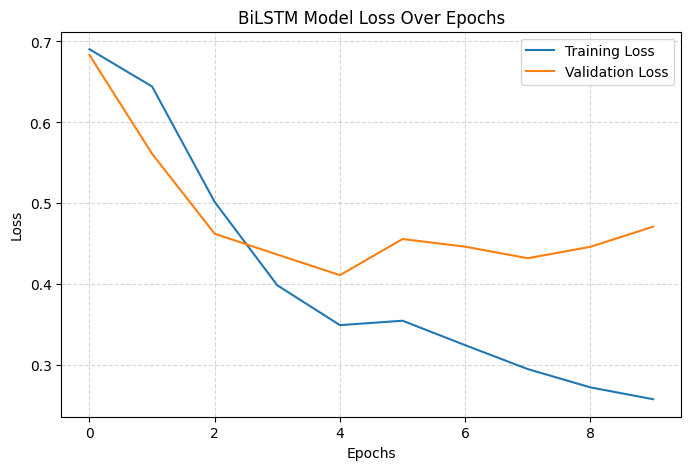

In [14]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('BiLSTM Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

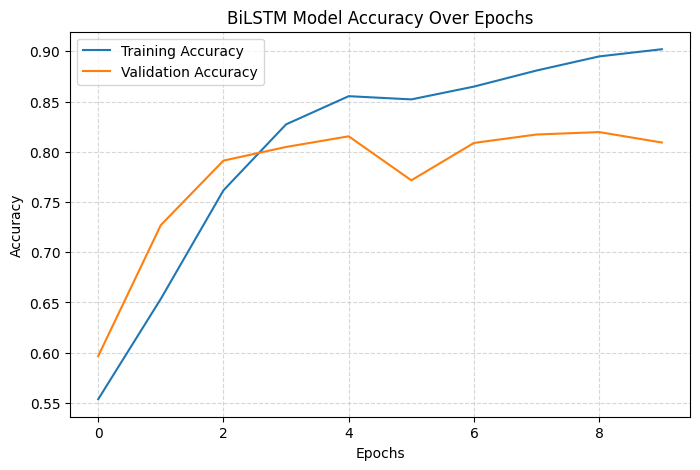

In [15]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_bilstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('BiLSTM Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

In [16]:
# Evaluate the model on the test set
test_loss, test_acc = bilstm_model.evaluate(X_test_vectorized, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8027 - loss: 0.4833
Test Loss: 0.48575082421302795
Test Accuracy: 0.8011199831962585


In [30]:
# Test the BiLSTM model on new sample reviews
predictions_bilstm = bilstm_model.predict(sample_reviews_vectorized)

# Display predictions for BiLSTM model with sentiment classification
for i, review in enumerate(sample_reviews):
    sentiment = "Positive" if predictions_bilstm[i][0] >= 0.5 else "Negative"
    print(f"BiLSTM Model Prediction for Review: '{review}'")
    print(f"Probability of Positive Sentiment: {predictions_bilstm[i][0]:.4f} ({sentiment})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
BiLSTM Model Prediction for Review: 'What a fantastic experience! The actors were phenomenal, and the direction was top-notch.'
Probability of Positive Sentiment: 0.2821 (Negative)

BiLSTM Model Prediction for Review: 'The movie was really bad. I would not recommend it to anyone.'
Probability of Positive Sentiment: 0.1837 (Negative)



# Construct an RNN model using BiGRU

## Train

In [22]:
# Construct a BiGRU-based RNN model
bigru_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the BiGRU model
bigru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the BiGRU model and store the history
history_bigru = bigru_model.fit(
    X_train_vectorized, y_train,
    epochs=10, batch_size=2048,
    validation_data=(X_val_vectorized, y_val)
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.5161 - loss: 0.6926 - val_accuracy: 0.5706 - val_loss: 0.6886
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6052 - loss: 0.6845 - val_accuracy: 0.5924 - val_loss: 0.6761
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6403 - loss: 0.6604 - val_accuracy: 0.6528 - val_loss: 0.6237
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7118 - loss: 0.5671 - val_accuracy: 0.7204 - val_loss: 0.5457
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.7686 - loss: 0.4913 - val_accuracy: 0.7710 - val_loss: 0.4770
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8201 - loss: 0.4024 - val_accuracy: 0.8034 - val_loss: 0.4316
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8503 - loss: 0.3408 - val_accuracy: 0.8084 - val_loss: 0.4343
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8643 - loss: 0.3196 - val_accuracy: 0.8184 - 

## Test and evaluate

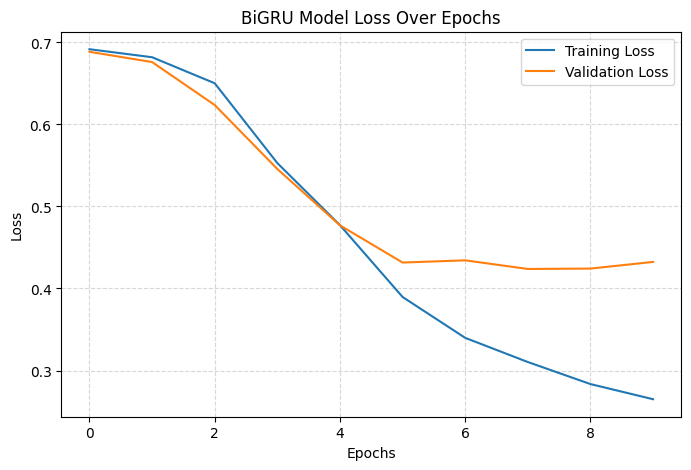

In [23]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_bigru.history['loss'], label='Training Loss')
plt.plot(history_bigru.history['val_loss'], label='Validation Loss')
plt.title('BiGRU Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

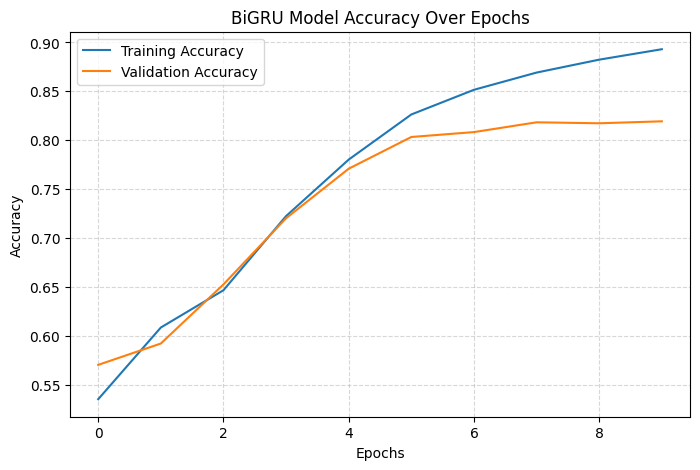

In [24]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_bigru.history['accuracy'], label='Training Accuracy')
plt.plot(history_bigru.history['val_accuracy'], label='Validation Accuracy')
plt.title('BiGRU Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

In [27]:
# Evaluate the model on the test set
test_loss, test_acc = bigru_model.evaluate(X_test_vectorized, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8084 - loss: 0.4445
Test Loss: 0.4476794898509979
Test Accuracy: 0.8059599995613098


In [32]:
# Test the BiGRU model on new sample reviews
predictions_bigru = bigru_model.predict(sample_reviews_vectorized)

# Display predictions for BiGRU model with sentiment classification
for i, review in enumerate(sample_reviews):
    sentiment = "Positive" if predictions_bigru[i][0] >= 0.5 else "Negative"
    print(f"BiGRU Model Prediction for Review: '{review}'")
    print(f"Probability of Positive Sentiment: {predictions_bigru[i][0]:.4f} ({sentiment})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
BiGRU Model Prediction for Review: 'What a fantastic experience! The actors were phenomenal, and the direction was top-notch.'
Probability of Positive Sentiment: 0.9608 (Positive)

BiGRU Model Prediction for Review: 'The movie was really bad. I would not recommend it to anyone.'
Probability of Positive Sentiment: 0.7666 (Positive)



# Compare the accuracy and runtime efficiency among LSTM, GRU, BiLSTM, and BiGRU models

## RNN model using GRU

* Review 1: Probability of Positive Sentiment: 0.8675 (Correctly classified as Positive)
* Review 2: Probability of Positive Sentiment: 0.0064 (Correctly classified as Negative)
* The GRU model performs well on both reviews, showing strong confidence in both classifications. This indicates that it has a good balance in recognizing both positive and negative sentiments.
* The GRU model is faster and more efficient compared to LSTM-based models (3 ms/step compared to 5 ms/step). However, the relatively higher loss indicates that there may be some issues in learning fine-grained patterns in the data (1.0414 compared to 0.4858).

## RNN model using BiLSTM

* Review 1: Probability of Positive Sentiment: 0.2821 (Incorrectly classified as Negative)
* Review 2: Probability of Positive Sentiment: 0.1837 (Correctly classified as Negative)
* The BiLSTM model correctly identifies the negative review but incorrectly classifies the clearly positive review as negative. This suggests that the model might be more conservative in assigning positive sentiment or may need more tuning to distinguish between strong positive and neutral/negative tones.
* The BiLSTM model has a higher accuracy than the GRU model and is better at capturing long-term dependencies due to the bidirectional structure (80.11% compared to 78.36%). However, it takes longer to train and is computationally more expensive and also showed a tendency to misclassify strongly positive reviews in the example provided.

## RNN model using BiGRU

* Review 1: Probability of Positive Sentiment: 0.9608 (Correctly classified as Positive)
* Review 2: Probability of Positive Sentiment: 0.7666 (Incorrectly classified as Positive)
* The BiGRU model shows high confidence in classifying the first review as positive, which is correct. However, it struggles with the second review, classifying it as positive with high confidence even though it is a strongly negative review. This indicates potential overconfidence or issues with understanding negative sentiment.
* The BiGRU model achieved the highest accuracy among all models. However, despite high accuracy, the BiGRU model struggled with the negative review in the test, indicating potential issues with recognizing strong negative sentiment.

## Conclusion

* The GRU model showed strong performance in correctly classifying both reviews, suggesting a good balance.
* The BiLSTM model was conservative in assigning positive sentiment and needs further tuning.
* The BiGRU model had the highest accuracy but showed overconfidence in the incorrect classification of negative sentiment.